# Simple Image Classifier

Beginner-friendly image classifier built with PyTorch and CIFAR-10.

<img alt="A photo of a man on an elephant with an ML-generated overlay showing objects in the frame" src="https://upload.wikimedia.org/wikipedia/commons/a/ae/DenseCap_%28Johnson_et_al.%2C_2016%29_%28cropped%29.png" width=450px>

An image classifier is an ML model that recognizes objects in images. We can build image classifiers by feeding tens of thousands of labelled images to a neural network. Tools like PyTorch train these networks by evaluating their performance against the dataset.

Let's build an image classifier that detects planes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. We'll download a dataset, configure a neural network, train a model, and evaluate its performance.

# Step 0: wandb

In [ ]:
%pip install wandb -Uq

In [ ]:
import wandb
wandb.login(key="170929178670aac645e7a271993c5a4979ee13eb")

In [ ]:
# Track metadata and hyperparameters with wandb.init
hyperparameters = dict(
    use_amp = False, # 是否使用混合精度训练？
    epochs = 3,
    batch_size = 10,
    lr=0.001, 
    momentum=0.9,
    dataset="CIFAR10",
    architecture="CNN")

wandb.init(project="image-classifier", name='debug', entity="ecust-bestcv", config=hyperparameters)

## Step 1: Download a dataset and preview images

A model is only as good as its dataset.

Training tools need lots of high-quality data to build accurate models. We'll use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 60,000 photos to build our image classifier. Get started by downloading the dataset with `torchvision` and previewing a handful of images from it.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Download the CIFAR-10 dataset to ./data
# 输入张量被归一化，每个通道的平均值为（0.5, 0.5, 0.5），标准差为（0.5, 0.5, 0.5）。这意味着，对于每个通道，输入张量中的值将被减去0.5，然后除以0.5
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader 是一个 PyTorch 的 DataLoader 对象，它负责对训练数据进行批量处理。具体来说，它会将训练数据集（这里是 trainset）按照给定的批量大小（这里是 batch_size）进行分割，然后通过重排序（这里是 shuffle=True）和多线程加速（这里是 num_workers=2）来提升数据处理的效率。

batch_size = hyperparameters['batch_size']

trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True, num_workers=2)
print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=False, num_workers=2)

# Our model will recognize these kinds of objects
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Grab images from our training data
# 创建一个图像标签的列表，然后使用这个列表来显示图像数据。
# 将一个数据加载器（即 trainloader）转换为一个迭代器（即 dataiter）。这样可以使用 for 循环或其他迭代方法来依次访问数据加载器中的每一个数据。
dataiter = iter(trainloader)
# 返回迭代器 dataiter 中的下一组图像和标签。迭代器是一种对象，它包含一组值，并允许通过迭代过程访问这些值。在循环中调用 next() 函数，可以遍历迭代器中的所有值。
images, labels = dataiter.next()

# 在一个 matplotlib 图中添加多个子图，并在每个子图中显示来自一个图像数组的图像
for i in range(batch_size):
    # Add new subplot
    # 使用 plt.subplot() 函数在一个网格中添加一个新的子图。该函数有三个参数：行数，列数和当前子图的索引。
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    # 将像素值归一化到 0 到 1 的范围内
    img = img / 2 + 0.5
    # 将图像数据从 PyTorch 的 Tensor 数据类型转换为 NumPy 数组。这样，就可以使用 NumPy 函数对图像数据进行处理，并使用 Matplotlib 绘图库绘制图像。
    npimg = img.numpy()
    # NumPy 数组在调用 plt.imshow 函数之前经过了转置，以便将图像数据从 PyTorch 的格式 (batch, channels, height, width) 转换为 Matplotlib 的格式 (height, width, channels)这样，就可以正确地在子图上显示图像。np.transpose 函数的参数元组是 (1, 2, 0)，表示的是将图像的第二维和第三维交换位置，并将第一维移到最后一维。
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    plt.title(classes[labels[i]])

plt.suptitle('Preview of Training Data', size=20)
plt.show()

# Step 2: Configure the neural network

Now that we have our dataset, we need to set up a neural network for PyTorch. Our neural network will transform an image into a description.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define a convolutional neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 2 维卷积层，它接收 3 通道输入图像，输出 6 通道特征图。卷积核大小为 5x5
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #  是一个线性（全连接）层，它将输入的 16 * 5 * 5 维向量映射到一个 120 维的输出向量。这个层中的参数包括一个 16 * 5 * 5 * 120 维的矩阵和一个长度为 120 的偏置向量
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 将输入的维度为 120 的张量变换为维度为 84 的张量
        self.fc2 = nn.Linear(120, 84)
        # 将输入的维度为 84 的张量变换为维度为 10 的张量
        self.fc3 = nn.Linear(84, 10)
    #定义了一个函数，该函数的作用是将输入的张量 x 经过定义的神经网络进行变换。在这里，self 是当前定义的神经网络对象本身，因此该函数中可以直接调用当前神经网络定义的层
    def forward(self, x):
        # 是经过定义的神经网络的第一层。在这一行代码中，首先通过 self.conv1 调用了定义的第一个卷积层，将输入张量 x 变换为第一层卷积层的输出张量。接下来，通过调用 PyTorch 中的激活函数 F.relu 对卷积层的输出张量进行激活，并通过调用定义的池化层 self.pool 对激活后的张量进行池化操作。最终，通过将池化层的输出张量赋值给变量 x，更新了 x 的值。
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # 将张量 x 拉成一维张量. 具体来说，torch.flatten(x, 1) 中的 1 是指定维度，表示将张量 x 从第二维开始压平。因此，假设输入的张量 x 的维度为 (batch_size, channels, height, width)，那么执行 x = torch.flatten(x, 1) 后，张量 x 的维度就会变为 (batch_size, channels * height * width)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()
lr = hyperparameters['lr']
momentum = hyperparameters['momentum']
# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr, momentum)

print("Your network is ready for training!")

In [ ]:
# 测试是否有可用的GPU "cuda:0"表示起始的device_id为0
device = torch.device("cuda:0" if torch.cuda.is_available()else "cpu")
print(device)
# 将模型复制到 GPU 或 CPU 中
net.to(device)

# Step 3: Train the network and save model
PyTorch trains our network by adjusting its parameters and evaluating its performance against our labelled dataset.

In [ ]:
# 从 PyTorch 中的 tqdm 模块中导入 tqdm 函数。tqdm 是一个用于显示进度条的 Python 库。通过调用 tqdm 函数，可以在训练模型时显示进度条，从而可以直观地了解训练的进度。
from tqdm import tqdm
# 在 PyTorch 中进行混合精度训练需要使用到 torch.cuda.amp 模块
# 使用 torch.cuda.amp.GradScaler 类来对梯度进行 scaling。GradScaler 类可以自动执行梯度的 scaling 和 un-scaling 操作，使得在使用梯度下降法进行参数更新时能够避免梯度 underflow 和 overflow 的问题。
if torch.cuda.is_available():
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler()

print("Training...")
# 用wandb跟踪PyTorch模型的权重和梯度,Track gradients with wandb.watch and everything else with wandb.log
wandb.watch(net)

# 训练计时器
import time
start_time = time.time()
EPOCHS = hyperparameters['epochs']
# 这个循环的目的是训练多个 epoch，每个 epoch 中都会迭代整个训练数据集。
for epoch in range(EPOCHS):
    running_loss = 0.0
    # 一个内层循环，这个循环的目的是迭代训练数据集。在这里，trainloader 是一个数据加载器，用于加载训练数据集。通过调用 enumerate 函数，我们可以在迭代数据集的同时获得每个数据在数据集中的索引。另外，tqdm 函数用于显示进度条。
    # desc=f"Epoch {epoch + 1} of {EPOCHS}" 指定了进度条的描述信息。leave=True 表示在循环结束之后，进度条仍然会保留在屏幕上。如果将 leave 参数设为 False，那么循环结束之后，进度条就会被清除掉。ncols=80 表示进度条的宽度为 80 个字符。
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch + 1} of {EPOCHS}", leave=True, ncols=80)):
        # 变量 "inputs "和 "labels "被赋予 "data "变量的值
        inputs, labels = data
        # 将输入和标签数据复制到 GPU 或 CPU 中
        inputs, labels = inputs.to(device), labels.to(device)

        use_amp = hyperparameters['use_amp']
        if torch.cuda.is_available() and use_amp:
            # 前向传播
            # 将模型和损失函数转换为混合精度
           with autocast():
             # 前向传播
             outputs = net(inputs)
             loss = criterion(outputs, labels)
             wandb.log({'epoch': epoch, 'loss': loss})
             # 反向传播
             # 通常在反向传播（计算模型参数相对于损失函数的梯度）之前会调用"zero_grad()"方法，以重置梯度为零。这是必要的，因为梯度在多个训练步骤中会累积，将它们重置为零可以确保梯度是对当前训练步骤正确的。通过将梯度重置为零，"optimizer.zero_grad()"方法可以防止梯度变得太大或太小，从而导致模型性能下降。
             # 梯度清零
             optimizer.zero_grad()
             scaler.scale(loss).backward()
             # 更新模型参数
             scaler.step(optimizer) # optimizer.step
             scaler.update()
        if not torch.cuda.is_available() or not use_amp:
            # 前向传播
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            wandb.log({'epoch': epoch, 'loss': loss})
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            # 更新模型参数
            # "optimizer.step()"中的"step"指模型参数的单次更新步骤。在每个训练步骤中，模型的参数将根据损失函数相对于这些参数的梯度被更新。这种更新有助于模型更好地拟合训练数据并提高其性能。"optimizer.step()"方法通过将优化算法（如随机梯度下降（SGD）或Adam）应用于计算出的梯度来执行此更新。通过调用"step()"方法，模型的参数将被更新，模型能够从训练数据中学习。
            optimizer.step()

# 记录结束时间
end_time = time.time()
# 计算训练时间
training_time = end_time - start_time
# 打印训练时间
print(f"Training time: {training_time / 60:.2f} minutes")
# 用wandb记录时间
wandb.log({"Training time": training_time / 60})

# Save our trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
# wandb.save是一个用于将文件（如模型检查点）保存到W&B的函数。它允许你把文件保存到W&B的云端，在那里可以从W&B的网页用户界面上访问和下载。
wandb.save('mymodel.h5')


# Step 4: Test the trained model

Let's test our model! Step 4 和 step 5 可以独立运行

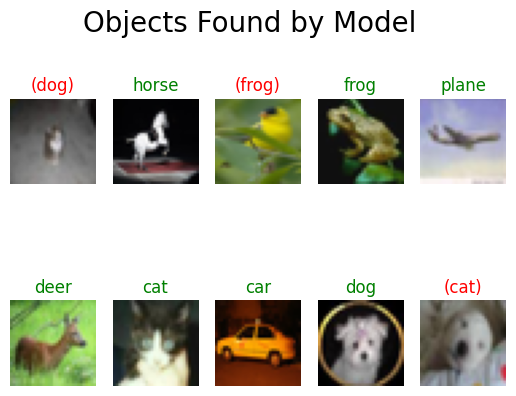

In [22]:
# Pick random photos from test set
# trainloader完成后dataiter == None
if dataiter == None:
    dataiter = iter(testloader)
# 返回迭代器 dataiter 中的下一组图像和标签。迭代器是一种对象，它包含一组值，并允许通过迭代过程访问这些值。在循环中调用 next() 函数，可以遍历迭代器中的所有值。
images, labels = dataiter.next()

# Load our model
net = Net()
# 使用 torch.load 函数加载了一个保存了模型参数的文件，并使用 net.load_state_dict 函数将这些参数加载到模型中
net.load_state_dict(torch.load(PATH))

# Analyze images
outputs = net(images)

# 使用 torch.max 函数找到了每个图像分析结果中最大值的索引，并将这些索引赋值给 predicted 变量
# _, predicted 表示的是一种解构赋值的方法。在解构赋值中，_ 表示一个占位符，它表示忽略这个变量。因此，在这个代码片段中，它表示只需要用 predicted 变量来接收 torch.max 函数返回的最大值索引即可，并且忽略它返回的最大值。
# torch.max(outputs, 1)表示求出outputs在第1维（即列）上的最大值，并将最大值的索引存储在predictions变量中。注意，用下划线（_）表示的是最大值的值，而不是索引，因此最大值的值会被丢弃。
_, predicted = torch.max(outputs, 1)

# Show results
for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
        # NumPy 数组在调用 plt.imshow 函数之前经过了转置，以便将图像数据从 PyTorch 的格式 (batch, channels, height, width) 转换为 Matplotlib 的格式 (height, width, channels)这样，就可以正确地在子图上显示图像。np.transpose 函数的参数元组是 (1, 2, 0)，表示的是将图像的第二维和第三维交换位置，并将第一维移到最后一维。
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    # 首先为当前图像指定了一个颜色值，默认为绿色。然后，它根据图像的预测标签和真实标签来决定是否需要将颜色改为红色。如果预测标签和真实标签不同，那么它会将颜色改为红色，并为图像添加括号。最后，使用这个颜色作为参数，调用 plt.title 函数为图像添加标题。
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)
    # 保存图片
    plt.savefig('Objects_Found_by_Model.png')
plt.suptitle('Objects Found by Model', size=20)
plt.show()

# 使用 wandb.Image 保存图像
wandb.log({"Example": wandb.Image("Objects_Found_by_Model.png")})


# Step 5: Evaluate model accuracy

Let's conclude by evaluating our model's overall performance.

In [ ]:
# Measure accuracy for each class
# correct_pred 和 total_pred 是两个字典，它们都包含了一个类别名称（例如 "cat" 或 "dog"）作为键，以及一个整数作为值。这两个字典的目的是统计每个类别的预测结果。具体来说，correct_pred 字典中的每个整数表示对应类别的正确预测次数，而 total_pred 字典中的每个整数表示对应类别的总预测次数。
# 在这个代码片段中，程序使用了一种称为字典推导的方法来初始化这两个字典。字典推导是一种创建字典的快捷方式，它和列表推导类似。在这个代码片段中，字典推导的格式是 {key: value for item in iterable}，它表示的是遍历 iterable 对象中的每个元素，并将元素作为键，将 value 作为值创建一个字典。在这个代码片段中，iterable 对象就是 classes 列表，value 的值是 0。因此，字典推导会在 classes 列表中遍历每个类别名称，并将类别名称作为键，值设为 0，创建一个字典。创建完成后，这个字典会赋值给 correct_pred 或 total_pred 变量。
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# 使用 torch.no_grad 函数禁用了梯度计算。这个函数的作用是在运行代码块内的模型训练过程时，暂时忽略梯度计算。在这个代码片段中，由于禁用了梯度计算，所以模型在运行过程中不会更新参数，也就是说，模型在这个代码块中运行时，实际上是在进行推理而不是训练。
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        outputs = net(images)

        # 使用 torch.max 函数找到了每个图像分析结果中最大值的索引，并将这些索引赋值给 predicted 变量
        # _, predicted 表示的是一种解构赋值的方法。在解构赋值中，_ 表示一个占位符，它表示忽略这个变量。因此，在这个代码片段中，它表示只需要用 predicted 变量来接收 torch.max 函数返回的最大值索引即可，并且忽略它返回的最大值。
        # torch.max(outputs, 1)表示求出outputs在第1维（即列）上的最大值，并将最大值的索引存储在predictions变量中。注意，用下划线（_）表示的是最大值的值，而不是索引，因此最大值的值会被丢弃。
        _, predictions = torch.max(outputs, 1)
    
        # collect the correct predictions for each class
        # "for label, prediction in zip(labels, predictions)" 是一个循环，它同时迭代两个列表 labels 和 predictions。函数 zip 将两个列表的元素组合在一起，创建一个包含元组的迭代器，每个元组都包含来自每个列表的一个元素。
        # 例如，如果 labels 是列表 [1, 2, 3]，而 predictions 是列表 ['a', 'b', 'c']，则 zip 函数将创建一个元组的迭代器 [(1, 'a'), (2, 'b'), (3, 'c')]。

        for label, prediction in zip(labels, predictions):
            
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    
    wandb.log({str(classname): accuracy})

In [ ]:
# End the W&B run
wandb.join()